In [1]:
#import random
import torch as tc
import numpy as np
import qutip as qt
import function as my
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def data_qubit_two_crosstalk(lista_J,dissipation,tfinal,N,O_op,device="cpu"):
    # Operadores de Pauli para cada qubit
    IX,IY,IZ = qt.tensor(qt.qeye(2) ,qt.sigmax()),qt.tensor(qt.qeye(2),qt.sigmay() ),qt.tensor(qt.qeye(2) ,qt.sigmaz())
    XI,YI,ZI = qt.tensor(qt.sigmax(),qt.qeye(2) ),qt.tensor(qt.sigmay(),qt.qeye(2) ),qt.tensor(qt.sigmaz(),qt.qeye(2) )
    XX,XY,XZ = qt.tensor(qt.sigmax(),qt.sigmax()),qt.tensor(qt.sigmax(),qt.sigmay()),qt.tensor(qt.sigmax(),qt.sigmaz())
    YX,YY,YZ = qt.tensor(qt.sigmay(),qt.sigmax()),qt.tensor(qt.sigmay(),qt.sigmay()),qt.tensor(qt.sigmay(),qt.sigmaz())
    ZX,ZY,ZZ = qt.tensor(qt.sigmaz(),qt.sigmax()),qt.tensor(qt.sigmaz(),qt.sigmay()),qt.tensor(qt.sigmaz(),qt.sigmaz())
    operadores = [IX,IY,IZ,
                  XI,YI,ZI,
                  XX,XY,XZ,
                  YX,YY,YZ,
                  ZX,ZY,ZZ]
    
    H = 0
    for i in range(len(lista_J)):
        H += 0.5*lista_J[i]*operadores[i]

    # Hamiltonian Lindbladian
    c_ops = [np.sqrt(dissipation[0])*qt.tensor(qt.sigmam(), qt.qeye(2)),
             np.sqrt(dissipation[1])*qt.tensor(qt.sigmaz(), qt.qeye(2)),
             np.sqrt(dissipation[2])*qt.tensor(qt.qeye(2) , qt.sigmam()),
             np.sqrt(dissipation[3])*qt.tensor(qt.qeye(2) , qt.sigmaz()),]
    # Estado inicial (cada qubit na superposição de |0> e |1>)
    # |+> = (|0> + |1>)/sqrt(2)
    theta1  = np.pi/4
    phi1    = 0.0 #np.pi/3
    ket_plus1 = (np.cos(theta1)*qt.basis(2, 0)+np.sin(theta1)*np.exp(1j*phi1)*qt.basis(2, 1))
    theta2  = np.pi/4
    phi2    = 0.0 #np.pi/5
    ket_plus2 = (np.cos(theta2)*qt.basis(2, 0)+np.sin(theta2)*np.exp(1j*phi2)*qt.basis(2, 1))

    psi0 = qt.tensor(ket_plus1, ket_plus2)
    
    # Lista de tempos para a evolução
    tlist = np.linspace(0.0, tfinal, N)

    # Solução da equação de Schrödinger
    options = qt.Options(nsteps = 100000, atol = 1e-14, rtol = 1e-14)
    result  = qt.mesolve(H, psi0, tlist, c_ops=c_ops, e_ops=O_op,options=options)

    expect  = tc.tensor( np.array( result.expect),device = device).transpose(0, 1)
    return expect

O_op =[ qt.tensor(qt.qeye(2) , qt.sigmax()),
        qt.tensor(qt.qeye(2) , qt.sigmay()),
        qt.tensor(qt.qeye(2) , qt.sigmaz()),
        qt.tensor(qt.sigmax(), qt.qeye(2) ),
        qt.tensor(qt.sigmax(), qt.sigmax()),
        qt.tensor(qt.sigmax(), qt.sigmay()),
        qt.tensor(qt.sigmax(), qt.sigmaz()),
        qt.tensor(qt.sigmay(), qt.qeye(2) ),
        qt.tensor(qt.sigmay(), qt.sigmax()),
        qt.tensor(qt.sigmay(), qt.sigmay()),
        qt.tensor(qt.sigmay(), qt.sigmaz()),
        qt.tensor(qt.sigmaz(), qt.qeye(2) ),
        qt.tensor(qt.sigmaz(), qt.sigmax()),
        qt.tensor(qt.sigmaz(), qt.sigmay()),
        qt.tensor(qt.sigmaz(), qt.sigmaz()),
        ]


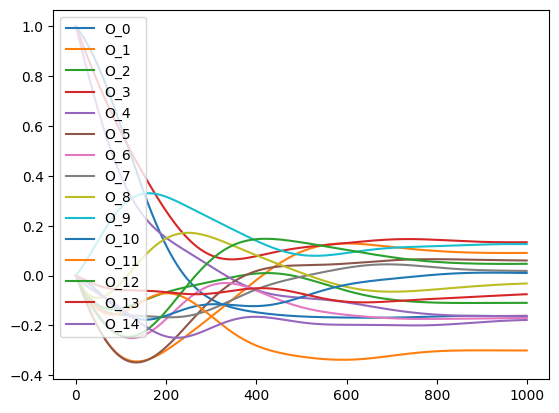

[-0.83658582 -0.43450468  0.2086114   0.98614408 -0.56222194 -0.7691777
  0.0729819   0.91572438 -0.96927131  0.57695035  0.25580219  0.9159642
  0.11879292 -0.5715653   0.12653102] [0.61836303 0.22511744 0.11768545 0.15270514]


In [3]:
Js          = np.random.uniform(-1,1,15)
dissipation = np.random.rand(4)

tfinal      = 2*np.pi
N           = 1000

valor_esperado_data  = data_qubit_two_crosstalk(Js,dissipation,tfinal,N,O_op,device="cpu")

for i in range(len(O_op)):
    plt.plot(valor_esperado_data[:,i].cpu() ,label=f"O_{i}")

plt.legend()
plt.show()
print(Js,dissipation)

In [4]:
neuronio = [50,50]
X_vector   = my.Rede(
    neuronio    = neuronio,
    input_      = 1,
    output_     = len(O_op),
    activation  =[tc.nn.Tanh()]*len(neuronio),
    creat_p     =True,
    N_of_paramater= 15 +4)
opt = tc.optim.Adam(X_vector.parameters(),
        lr = 0.001 )
time =  tc.linspace(
        0,
        tfinal,
        N,
        dtype   = tc.float32,
        requires_grad = True).reshape((-1, 1))
index_data = np.random.randint(0,N,size=20)
X_vector.parametro

Parameter containing:
tensor([0.5456, 0.8246, 0.5942, 0.4360, 0.7686, 0.5802, 0.0154, 0.5979, 0.8284,
        0.8067, 0.3919, 0.0469, 0.5647, 0.7698, 0.5385, 0.4214, 0.3771, 0.3262,
        0.7291], requires_grad=True)

In [5]:
epocas  = 20000
LOSS    = []
LOSS1   = []
LOSS2   = []
hisorty_of_param = []
for _ in tqdm(range(epocas)):
    ####### Forward pass #######
    y  = X_vector(time)     
    
    ######## Los edo #######
    dX_dt = []
    for i in range(y.shape[1]):
        dX_dt.append(tc.autograd.grad(outputs = y[:, i], 
                                    inputs = time,
                                    grad_outputs = tc.ones_like(y[:, i]),
                                    #retain_graph = True,
                                    create_graph = True)[0])
    dX_dt   = tc.cat(dX_dt, dim=1)
    
    IX,IY,IZ,XI,XX,XY,XZ = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4],y[:, 4:5], y[:, 5:6],y[:, 6:7]
    YI,YX,YY,YZ,ZI,ZX,ZY,ZZ = y[:, 7:8], y[:, 8:9], y[:, 9:10],y[:, 10:11], y[:, 11:12], y[:,12:13], y[:,13:14], y[:,14:15]

    JIX,JIY,JIZ,JXI,JYI,JZI,JXX,JXY,JXZ,JYX,JYY,JYZ,JZX,JZY,JZZ,gamma1,gamma2,gamma3,gamma4 = X_vector.parametro
    
    LOSS_edo  = 0
    LOSS_edo += (dX_dt[:,0:1] - ( +IX*(-0.5*gamma3 - 2.0*gamma4) +IY*(-1.0*JIZ) +IZ*(1.0*JIY) +(-1.0*JXZ)*XY +JXY*XZ +(-1.0*JYZ)*YY +(1.0*JYY)*YZ +(-1.0*JZZ)*ZY +(1.0*JZY)*ZZ))**2
    LOSS_edo += (dX_dt[:,1:2] - ( +IX*(1.0*JIZ) +IY*(-0.5*gamma3 - 2.0*gamma4) +IZ*(-1.0*JIX) +(1.0*JXZ)*XX +(-1.0*JXX)*XZ +JYZ*YX +(-1.0*JYX)*YZ +(1.0*JZZ)*ZX +(-1.0*JZX)*ZZ))**2
    LOSS_edo += (dX_dt[:,2:3] - ( (-1.0*gamma3) +IX*(-1.0*JIY) +IY*(1.0*JIX) +IZ*(-1.0*gamma3) +(-1.0*JXY)*XX +(1.0*JXX)*XY +(-1.0*JYY)*YX +JYX*YY +(-1.0*JZY)*ZX +(1.0*JZX)*ZY))**2
    LOSS_edo += (dX_dt[:,3:4] - ( +XI*(-0.5*gamma1 - 2.0*gamma2) +(-1.0*JZI)*YI +(-1.0*JZX)*YX +(-1.0*JZY)*YY +(-1.0*JZZ)*YZ +(1.0*JYI)*ZI +JYX*ZX +(1.0*JYY)*ZY +(1.0*JYZ)*ZZ))**2
    LOSS_edo += (dX_dt[:,4:5] - ( +IY*(-1.0*JXZ) +IZ*(1.0*JXY) +XX*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIZ)*XY +JIY*XZ +(-1.0*JZX)*YI +(-1.0*JZI)*YX +(1.0*JYX)*ZI +JYI*ZX))**2
    LOSS_edo += (dX_dt[:,5:6] - ( +IX*(1.0*JXZ) +IZ*(-1.0*JXX) +(1.0*JIZ)*XX +XY*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIX)*XZ +(-1.0*JZY)*YI +(-1.0*JZI)*YY +(1.0*JYY)*ZI +JYI*ZY))**2
    LOSS_edo += (dX_dt[:,6:7] - ( +IX*(-1.0*JXY) +IY*(1.0*JXX) +XI*(-1.0*gamma3) +(-1.0*JIY)*XX +(1.0*JIX)*XY +XZ*(-0.5*gamma1 - 2.0*gamma2 - 1.0*gamma3) +(-1.0*JZZ)*YI +(-1.0*JZI)*YZ +(1.0*JYZ)*ZI +(1.0*JYI)*ZZ))**2
    LOSS_edo += (dX_dt[:,7:8] - ( +(1.0*JZI)*XI +(1.0*JZX)*XX +JZY*XY +(1.0*JZZ)*XZ +YI*(-0.5*gamma1 - 2.0*gamma2) +(-1.0*JXI)*ZI +(-1.0*JXX)*ZX +(-1.0*JXY)*ZY +(-1.0*JXZ)*ZZ))**2
    LOSS_edo += (dX_dt[:,8:9] - ( +IY*(-1.0*JYZ) +IZ*(1.0*JYY) +(1.0*JZX)*XI +(1.0*JZI)*XX +YX*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIZ)*YY +JIY*YZ +(-1.0*JXX)*ZI +(-1.0*JXI)*ZX))**2
    LOSS_edo += (dX_dt[:,9:10] - ( +IX*JYZ +IZ*(-1.0*JYX) +JZY*XI +(1.0*JZI)*XY +(1.0*JIZ)*YX +YY*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIX)*YZ +(-1.0*JXY)*ZI +(-1.0*JXI)*ZY))**2
    LOSS_edo += (dX_dt[:,10:11] - ( +IX*(-1.0*JYY) +IY*JYX +(1.0*JZZ)*XI +(1.0*JZI)*XZ +YI*(-1.0*gamma3) +(-1.0*JIY)*YX +(1.0*JIX)*YY +YZ*(-0.5*gamma1 - 2.0*gamma2 - 1.0*gamma3) +(-1.0*JXZ)*ZI +(-1.0*JXI)*ZZ))**2
    LOSS_edo += (dX_dt[:,11:12] - ( (-1.0*gamma1) +(-1.0*JYI)*XI +(-1.0*JYX)*XX +(-1.0*JYY)*XY +(-1.0*JYZ)*XZ +(1.0*JXI)*YI +(1.0*JXX)*YX +JXY*YY +(1.0*JXZ)*YZ +ZI*(-1.0*gamma1)))**2
    LOSS_edo += (dX_dt[:,12:13] - ( +IX*(-1.0*gamma1) +IY*(-1.0*JZZ) +IZ*(1.0*JZY) +(-1.0*JYX)*XI +(-1.0*JYI)*XX +(1.0*JXX)*YI +(1.0*JXI)*YX +ZX*(-1.0*gamma1 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIZ)*ZY +(1.0*JIY)*ZZ))**2
    LOSS_edo += (dX_dt[:,13:14] - ( +IX*(1.0*JZZ) +IY*(-1.0*gamma1) +IZ*(-1.0*JZX) +(-1.0*JYY)*XI +(-1.0*JYI)*XY +JXY*YI +(1.0*JXI)*YY +(1.0*JIZ)*ZX +ZY*(-1.0*gamma1 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIX)*ZZ))**2
    LOSS_edo += (dX_dt[:,14:15] - ( +IX*(-1.0*JZY) +IY*(1.0*JZX) +IZ*(-1.0*gamma1) +(-1.0*JYZ)*XI +(-1.0*JYI)*XZ +(1.0*JXZ)*YI +(1.0*JXI)*YZ +ZI*(-1.0*gamma3) +(-1.0*JIY)*ZX +(1.0*JIX)*ZY +ZZ*(-1.0*gamma1 - 1.0*gamma3)))**2
    LOSS_edo = LOSS_edo.mean() 
    ####### loss data(expected values) #######
    LOSS_data = tc.mean((y[index_data,:]  - valor_esperado_data[index_data,:])**2) 
    
    ####### Loss total #######
    loss_i = LOSS_edo*0.01 + LOSS_data
    
    ####### Backpropagation #######
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    LOSS1.append(LOSS_edo.cpu().detach().numpy())
    LOSS2.append(LOSS_data.cpu().detach().numpy())
    LOSS.append(loss_i.cpu().detach().numpy())

100%|██████████| 20000/20000 [25:11<00:00, 13.24it/s] 


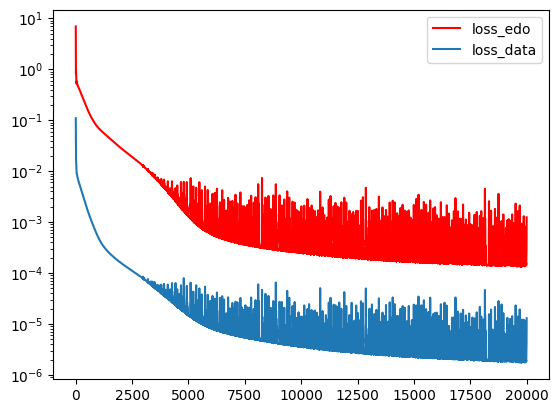

Valor final: Parameter containing:
tensor([-0.8239, -0.4341,  0.2016,  0.9720, -0.5597, -0.7663,  0.0604,  0.9166,
        -0.9605,  0.5761,  0.2538,  0.9115,  0.1229, -0.5690,  0.1233,  0.6164,
         0.2244,  0.1174,  0.1537], requires_grad=True)


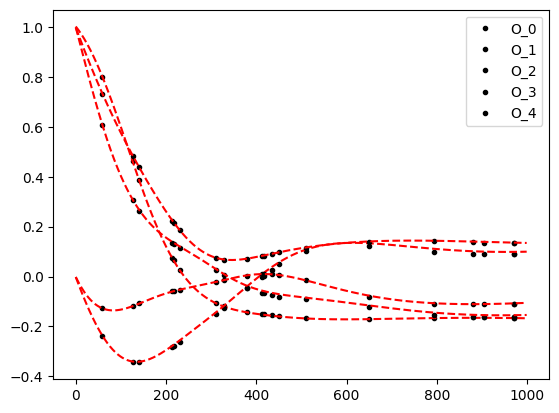

In [6]:
#plt.plot(LOSS,"k.",label="loss_total")
plt.plot(LOSS1,'r-',label="loss_edo")
plt.plot(LOSS2,label="loss_data")
plt.yscale("log")
plt.legend()
plt.show()
print("Valor final:",X_vector.parametro)


X_vector.eval()
X_  = X_vector(time).detach().numpy()

for i in range(5):
    plt.plot(index_data,valor_esperado_data[index_data,i].cpu(),"k." ,label=f"O_{i}")
    plt.plot(X_[:,i],"r--")

# plt.plot(X_[:,3],"--",label="sigmaI_Y")

plt.legend()
plt.show()

In [15]:
abs(X_vector.parametro - tc.tensor(Js.tolist() + dissipation.tolist()))

tensor([-0.0152, -0.0010,  0.0338,  0.0143, -0.0044, -0.0038,  0.1717,  0.0009,
        -0.0090,  0.0014,  0.0079,  0.0049,  0.0350, -0.0044,  0.0256,  0.0032,
         0.0031,  0.0027,  0.0068], grad_fn=<DivBackward0>)